In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
42855,NaN,NaN,International,2020-09-08,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42856,NaN,NaN,International,2020-09-09,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42857,NaN,NaN,International,2020-09-10,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


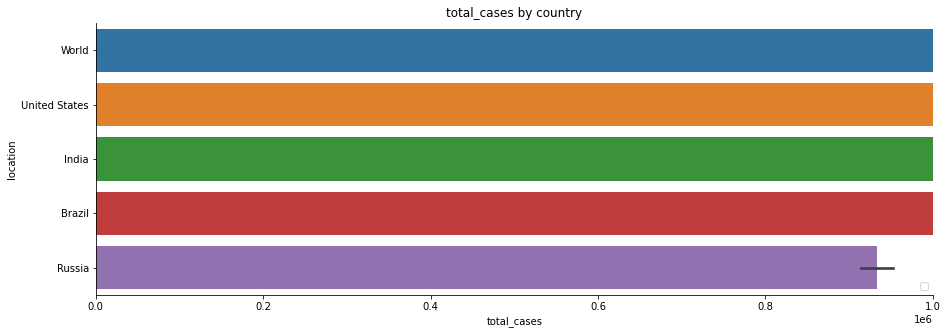

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


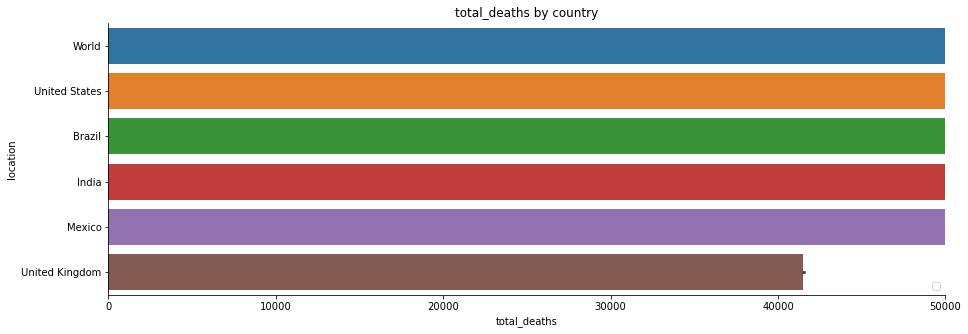

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


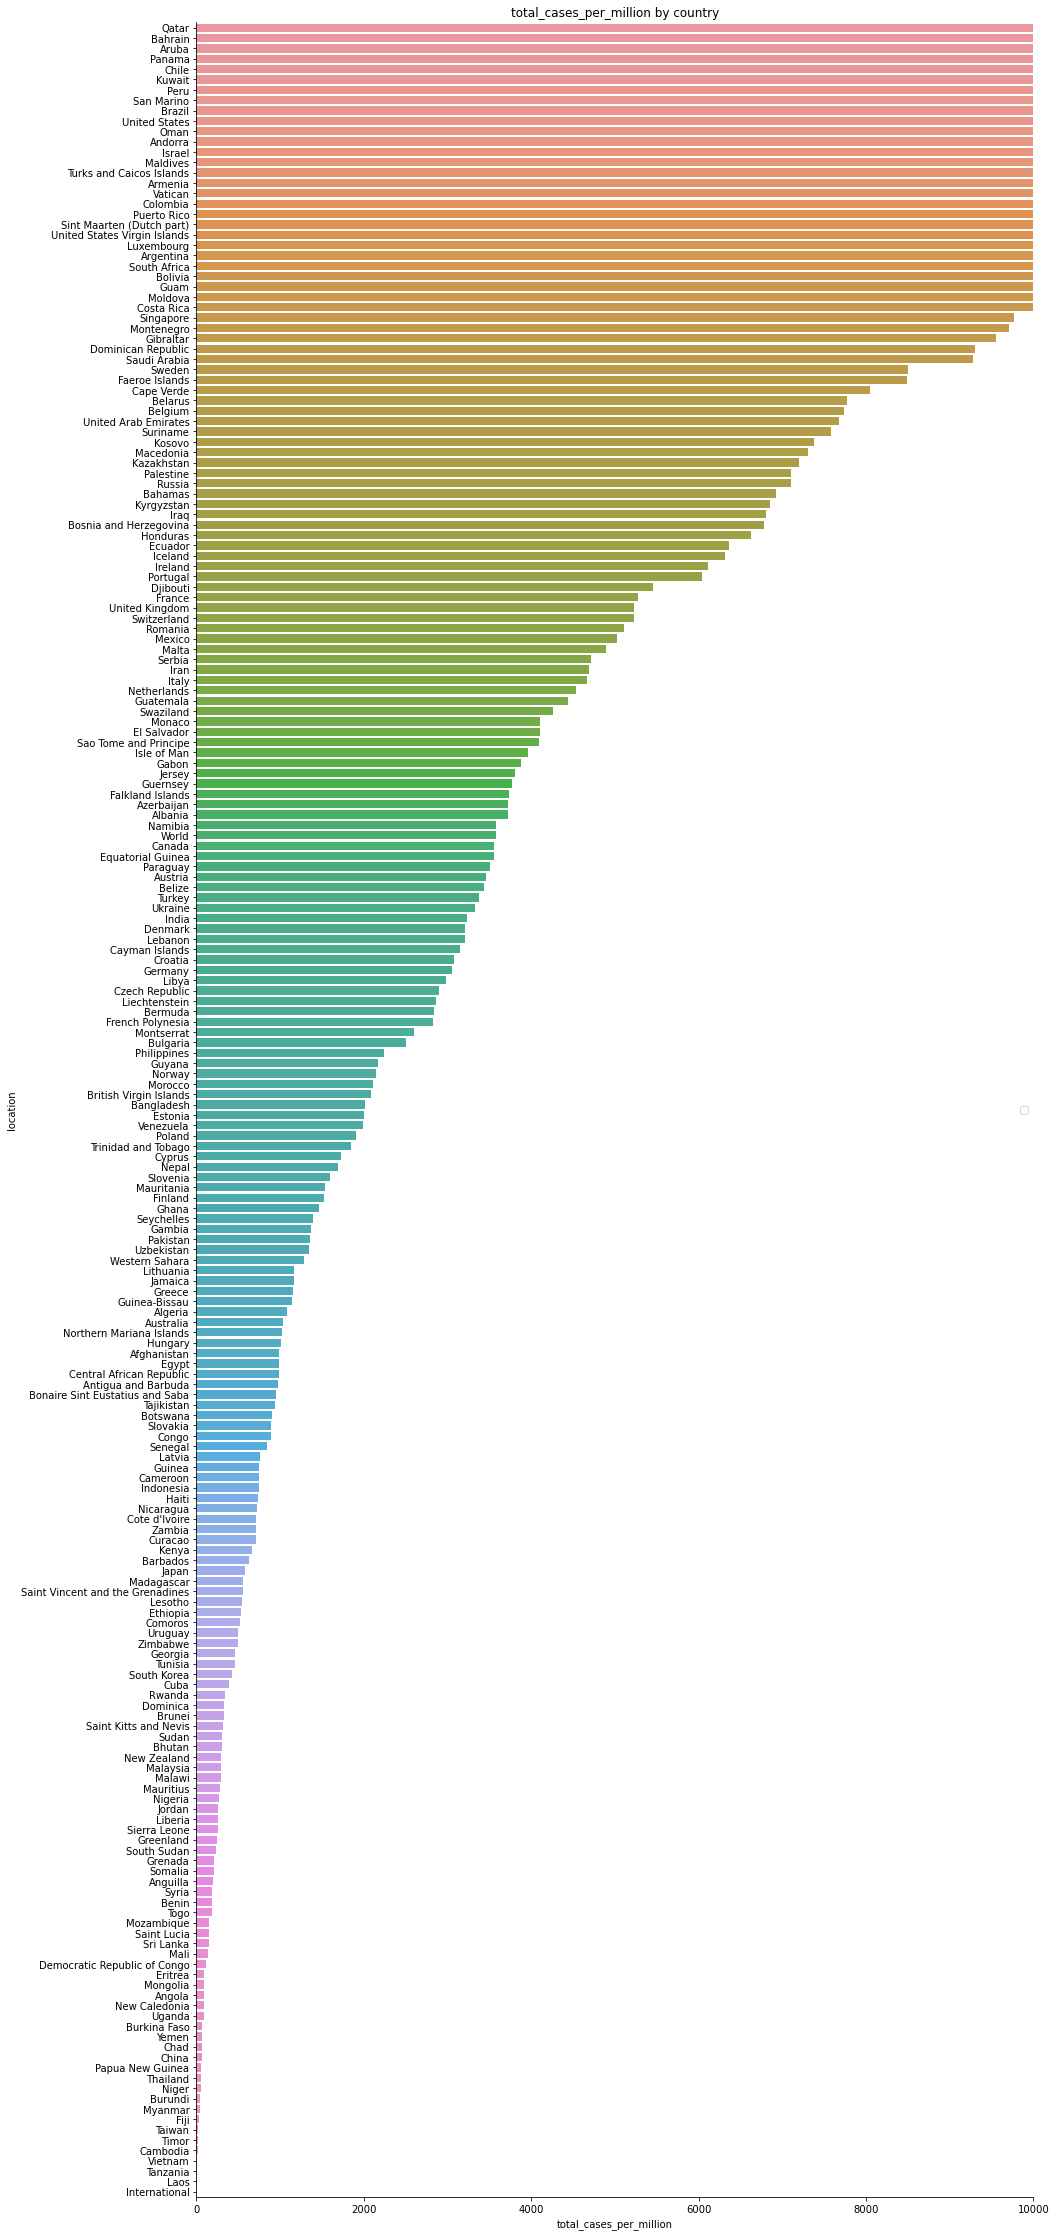

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


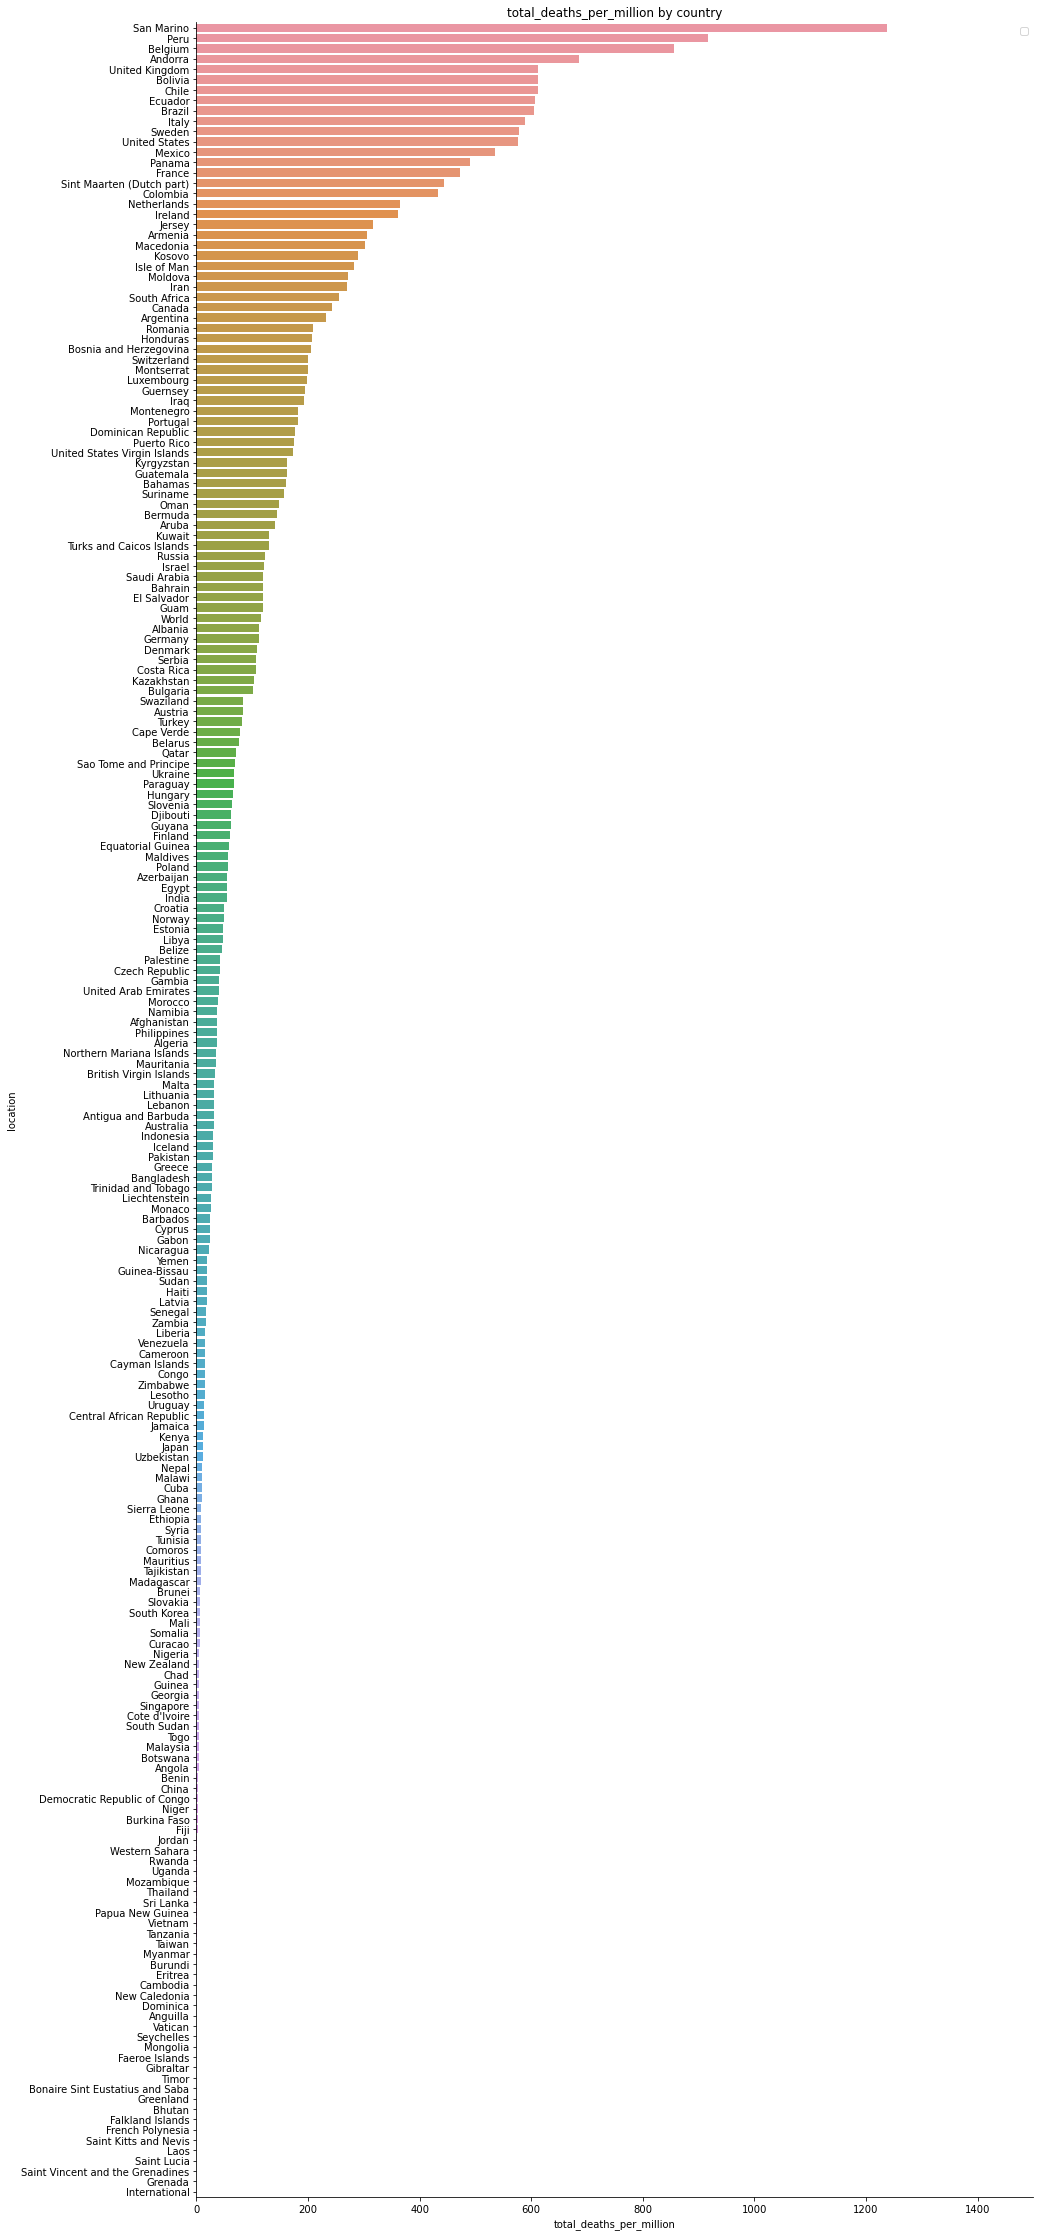

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

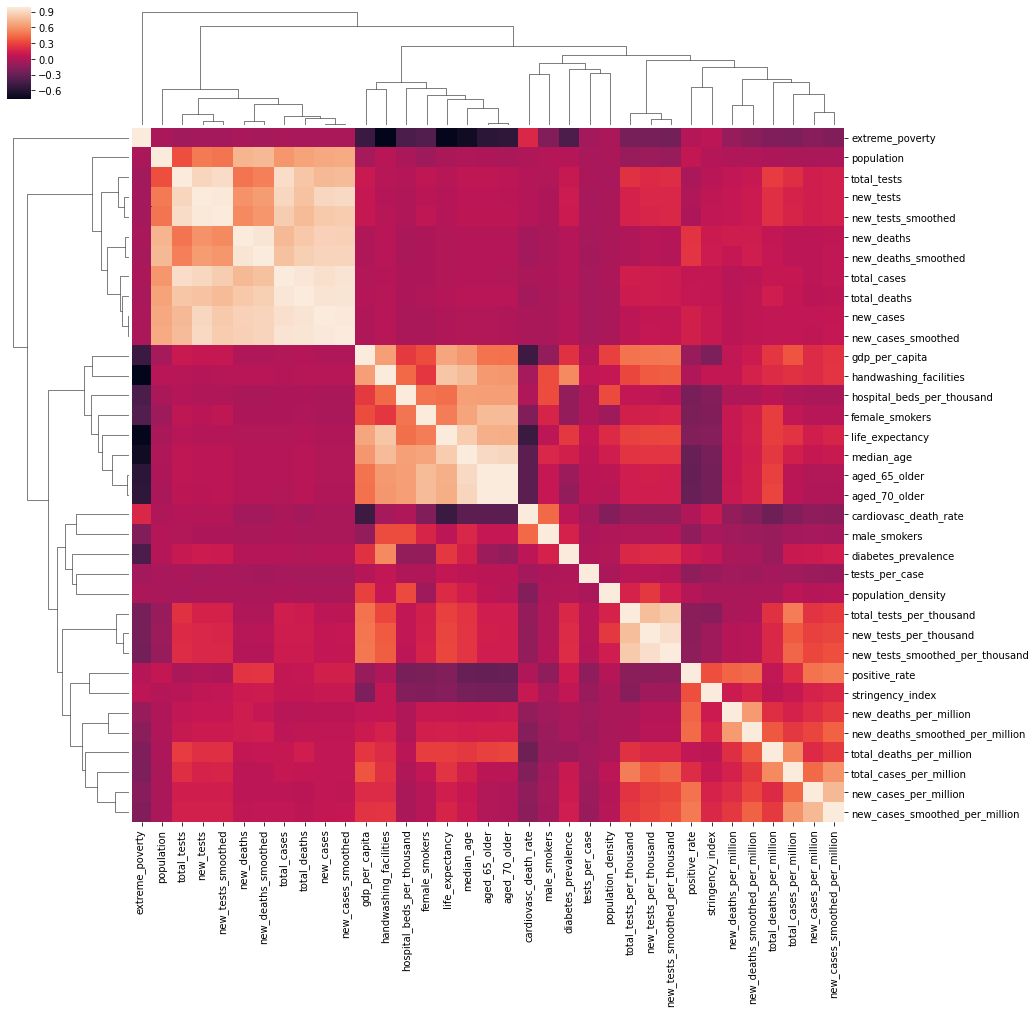

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9990525817687335 (+/- 0.0010374631140927894)
Coef :  [1.03422194e+00 9.35201328e-05 9.75695996e-05]
3 Last_days :  [[27376415 27620019 27891329]]
Today :  27891329
Prediction + :  520784
Tomorow :  28412113
                                     
--------- Total Death -----------------
                                     
R^2: 0.999631286328933 (+/- 0.00010166112864766757)
Coef :  [0.13180037 0.42591958 0.45258376]
3 Last_days :  [[893163 898132 903991]]
Today :  903991
Prediction + :  8303
Tomorow :  912294
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9944781888298463 (+/- 0.002909268654860173)
Coef :  [-0.73638417  0.77311884  0.96674824]
3 Last_days :  [[328980 335524 344101]]
Today :  344101
Prediction + :  5776
Tomorow :  349877
                                     
--------- Total Death -----------------
                                     
R^2: 0.5495541078492961 (+/- 0.6267739173651262)
Coef :  [-0.75008369  0.78872211  0.96035537]
3 Last_days :  [[30726 30764 30794]]
Today :  30794
Prediction + :  49
Tomorow :  30843
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9360113479366009 (+/- 0.05442730846767916)
Coef :  [-0.32721913 -0.01524846  1.33673248]
3 Last_days :  [[90079 90087 90100]]
Today :  90100
Prediction + :  18
Tomorow :  90118
                                     
--------- Total Death -----------------
                                     
R^2: -113.69313051443636 (+/- 162.08847848847944)
Coef :  [-0.07727054  0.01245714  1.0566323 ]
3 Last_days :  [[4732 4733 4733]]
Today :  4733
Prediction + :  5
Tomorow :  4738
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9601719029026491 (+/- 0.0553189879605324)
Coef :  [-0.82089468  0.89667369  0.92358078]
3 Last_days :  [[278784 280153 281853]]
Today :  281853
Prediction + :  1205
Tomorow :  283058
                                     
--------- Total Death -----------------
                                     
R^2: 0.6733680992664034 (+/- 0.4370817079511189)
Coef :  [-0.82482271  0.89776938  0.92611684]
3 Last_days :  [[35553 35563 35577]]
Today :  35577
Prediction + :  28
Tomorow :  35605
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.6034746061779053 (+/- 0.5507482513880271)
Coef :  [-0.37210757  0.19803714  1.17853375]
3 Last_days :  [[525549 534513 543379]]
Today :  543379
Prediction + :  7538
Tomorow :  550917
                                     
--------- Total Death -----------------
                                     
R^2: -0.04743174359767521 (+/- 1.1869076621669659)
Coef :  [-0.7276822  0.6335198  1.0931661]
3 Last_days :  [[29516 29594 29628]]
Today :  29628
Prediction + :  68
Tomorow :  29696
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9794881263098211 (+/- 0.028428028467037906)
Coef :  [0.0687651  0.4663772  0.47851804]
3 Last_days :  [[6300671 6327793 6359720]]
Today :  6359720
Prediction + :  83490
Tomorow :  6443210
                                     
--------- Total Death -----------------
                                     
R^2: 0.9802965731036885 (+/- 0.026349722504636644)
Coef :  [-0.47916575  0.70448297  0.7773268 ]
3 Last_days :  [[189208 189679 190815]]
Today :  190815
Prediction + :  849
Tomorow :  191664
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9267630417894678 (+/- 0.10280248123004634)
Coef :  [-0.70080944  0.83841756  0.86279123]
3 Last_days :  [[350100 352560 355219]]
Today :  355219
Prediction + :  2064
Tomorow :  357283
                                     
--------- Total Death -----------------
                                     
R^2: 0.33443379225241143 (+/- 0.8975791782694135)
Coef :  [-0.76859581  0.83118098  0.93674501]
3 Last_days :  [[41554 41586 41594]]
Today :  41594
Prediction + :  59
Tomorow :  41653
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9447214556451874 (+/- 0.0770257602434851)
Coef :  [-0.78891151  0.85431125  0.93438444]
3 Last_days :  [[252298 253474 255366]]
Today :  255366
Prediction + :  1064
Tomorow :  256430
                                     
--------- Total Death -----------------
                                     
R^2: 0.34474347461674587 (+/- 0.9161968851931612)
Coef :  [-0.78815313  0.84031559  0.94710369]
3 Last_days :  [[9329 9338 9341]]
Today :  9341
Prediction + :  13
Tomorow :  9354
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: -19.21812393197869 (+/- 28.59098360274873)
Coef :  [0.25923657 0.37697439 0.37457173]
3 Last_days :  [[388810 391112 393425]]
Today :  393425
Prediction + :  3658
Tomorow :  397083
                                     
--------- Total Death -----------------
                                     
R^2: 0.9530632702704452 (+/- 0.06580943433101652)
Coef :  [0.0492657  0.48565866 0.47611886]
3 Last_days :  [[22410 22542 22669]]
Today :  22669
Prediction + :  236
Tomorow :  22905
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9994735291328173 (+/- 0.00046907922424655244)
Coef :  [-0.69630698  0.82999331  0.8637241 ]
3 Last_days :  [[281509 283270 284943]]
Today :  284943
Prediction + :  1395
Tomorow :  286338
                                     
--------- Total Death -----------------
                                     
R^2: 0.999391944531126 (+/- 0.0003551651441816708)
Coef :  [-0.81191293  0.89354489  0.91596202]
3 Last_days :  [[6730 6782 6837]]
Today :  6837
Prediction + :  41
Tomorow :  6878
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.4508136526374244 (+/- 0.7718268963711226)
Coef :  [-0.16997327  0.51807024  0.66535338]
3 Last_days :  [[4147794 4162073 4197889]]
Today :  4197889
Prediction + :  53469
Tomorow :  4251358
                                     
--------- Total Death -----------------
                                     
R^2: 0.4807857391085757 (+/- 0.7292755379159422)
Coef :  [-0.10037184  0.51408945  0.59733294]
3 Last_days :  [[126960 127464 128539]]
Today :  128539
Prediction + :  1315
Tomorow :  129854
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(27891329, 903991, 28412113, 912294),
 (344101, 30794, 349877, 30843),
 (281853, 35577, 283058, 35605),
 (543379, 29628, 550917, 29696),
 (6359720, 190815, 6443210, 191664),
 (90100, 4733, 90118, 4738),
 (355219, 41594, 357283, 41653),
 (255366, 9341, 256430, 9354),
 (393425, 22669, 397083, 22905),
 (284943, 6837, 286338, 6878),
 (4197889, 128539, 4251358, 129854)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-10,France,349877.0,0.0,30843.0,0.0,0.0,0.0
0,2020-09-10,China,90118.0,0.0,4738.0,0.0,0.0,0.0
0,2020-09-10,Italy,283058.0,0.0,35605.0,0.0,0.0,0.0
0,2020-09-10,Spain,550917.0,0.0,29696.0,0.0,0.0,0.0
0,2020-09-10,United States,6443210.0,0.0,191664.0,0.0,0.0,0.0
0,2020-09-10,World,28412113.0,0.0,912294.0,0.0,0.0,0.0
0,2020-09-10,United Kingdom,357283.0,0.0,41653.0,0.0,0.0,0.0
0,2020-09-10,Germany,256430.0,0.0,9354.0,0.0,0.0,0.0
0,2020-09-10,Iran,397083.0,0.0,22905.0,0.0,0.0,0.0
0,2020-09-10,Turkey,286338.0,0.0,6878.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")